In [525]:
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import signal as signal
from scipy import constants as const
from scipy import fftpack
from scipy import optimize
from iminuit import Minuit

In [526]:
""" Basic Parameters """
global samp  #sampleing frequency  (Hz)
global NET  # Noise Equivalent Temperature (uKsqrt(s))
global tau  # time constant of detector (s)
global tstop # measurement time (s)
global SNR # Signal to Noise Ratio

samp=  3200
NET = 300 
tau =0.004
tstop = 10.
SNR = 10

""" stimulator part """
stm = np.array([1,2,4,5,10,20,40,50,75,80])
rflat = 0.8

In [527]:
def RecWOP(x,a,b):
    
    y = []

    y1 = [1.0/a/2*x[i]+0.5 for i in range(len(x)) if  x[i]<a]
    y.extend(y1)
    y2 = [1  for i in range(len(x)) if x[i]>=a and x[i]<=a+b]
    y.extend(y2)
    y3 = [1.0-1.0/a/2*(x[i]-a-b)  for i in range(len(x)) if x[i]>a+b and x[i]<3*a+b]
    y.extend(y3)
    y4 = [0   for i in range(len(x)) if x[i]>=3*a+b and x[i]<=3*a+2*b]
    y.extend(y4)
    y5 = [1.0/a/2*(x[i]-3*a-2*b) for i in range(len(x)) if x[i]>3*a+2*b and x[i]<=4*a+2*b]
    y.extend(y5)

    return y

def RecW(x,a,b,c):

    Nsp =  int(round(x[-1]*c))
    xsp = np.array((np.array_split(x, Nsp)))
    
    yRec  = []

    for i in range(Nsp):
        yOP = RecWOP(xsp[0],tilt,flat)
        yRec.extend(yOP)
        
    return yRec


In [528]:
def GetSignal(x,a,b,c):
    ys = RecW(x,a,b,c)
    xf = np.arange(0,len(ys)/samp,1.0/samp)

    yexp = np.exp(-xf/tau)/tau
    fft_exp = fftpack.fft(yexp)
    fft_sig = fftpack.fft(ys)
    
    in2 = fft_exp*fft_sig/samp
    signal =  fftpack.ifft(in2)
    
    return xf, signal.real + np.random.normal(0, 1.0/SNR, len(xf)) 

def GetOnePhase(x,a,b,c):
    
    Nsp =  int(round(x[-1]*c))
    xsp = np.array((np.array_split(x, Nsp)))
    
    ys = RecWOP(xsp[0],a,b)
    
    xf = np.arange(0,len(ys)/samp,1.0/samp)

    yexp = np.exp(-xf/tau)/tau
    fft_exp = fftpack.fft(yexp)
    fft_sig = fftpack.fft(ys)
    
    in2 = fft_exp*fft_sig/samp
    signal =  fftpack.ifft(in2)

    sigsum = signal.real
    sigmam = []
    
    for i in range(Nsp-1):
        sigsum= sigsum+signal.real+np.random.normal(0, 1.0/SNR, len(xf))
        sigmam.append(np.random.normal(0, 1.0/SNR, len(xf)))
        
    return xf, sigsum/Nsp, np.std(sigmam, axis=0)

def GetNoise(x,a,b,c):
    ys = RecW(x,a,b,c)
    xf = np.arange(0,len(ys)/samp,1.0/samp)
    
    return  np.random.normal(0, 1.0/SNR, len(xf))


In [529]:
def FindPeak(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    fft_sig = fftpack.fft(y)
    
    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)/len(x)*2
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 0.01 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    peak = max(amp[maximal_idx])
    ipeak = np.where(amp==max(amp[maximal_idx]))[0][0]          

    return peak

def  plotFFT(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)/len(x)*2
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 0.01 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    plt.plot(freqList,amp)
    plt.xlim(0,50)
    plt.yscale('log')

def NoiseFFT(x, y, freq):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)
    
    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)/len(x)*2
    ph = np.arctan2(fft_sig.imag,fft_sig.real)
    
    return amp[freq]

In [530]:
def rect(x,f,a,b,c,d,p1,p2,p3,p4,off):
    return  (4/const.pi)*(a*np.sin(2*const.pi*f*x+p1)+b*np.sin(2*const.pi*3*f*x+p2)+c*np.sin(2*const.pi*5*f*x+p3)+d*np.sin(2*const.pi*7*f*x+p4))+off

def Find1stPeak(x,y):
    pinit=[fstm,1,1/3,1/5,1/7,0,0,0,0,0.5]

    params,cov = optimize.curve_fit(rect, x, y, pinit)

    stderr = np.sqrt(np.diag(cov)) 
        
    return params[1]

def PlotSignal(x,y):

    pinit=[fstm,1,1/3,1/5,1/7,0,0,0,0,0.5]
    params,cov = optimize.curve_fit(rect, x, y, pinit)

    stderr = np.sqrt(np.diag(cov)) 
    
    plt.plot(x,y)
    plt.xlim(0,1)
    plt.plot(x, rect(x,params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],params[8],params[9]))


In [531]:
def LSQ(f, a, b, c, d, p1, p2, p3, p4,off):
    return np.sum((y-rect(xf,f,a,b,c,d,p1,p2,p3,p4,off))**2/yvar**2)


def MinuitMinimize(x,y, yvar):        

    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)

    m.get_param_states()
    m.migrad()

    return abs(m.values[1]), m.errors[1]

def ShowFitResult(x,y):        
    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)
 
    #m.get_param_states()
    m.migrad()
    m.hesse()
    m.minos()
    print(m.values)
    print(m.errors)


def PlotMinuitSignal(x,y, yvar):
    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)
    
    m.migrad()
        
    plt.errorbar(x,y,yvar)
    plt.plot(x, rect(x,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6],m.values[7],m.values[8],m.values[9]))
    #plt.xlim(0,1.0)
    plt.xlabel("time (s)")
    plt.ylabel("amplitude(a.u)")

In [532]:
def func(x,t,A):
    return  A/np.sqrt(1+(2*const.pi*t*x)**2)

def FitLPF(f, g, ge):
    
    def LSQLPF(t,A):
        return np.sum((g-func(f,t,A))**2/ge**2)

    pinit = [tau,1]
    perror=[0.01,0.01]
    
    m = Minuit(LSQLPF, t=pinit[0], A=pinit[1], 
               error_t=perror[0], error_A=perror[1], 
                limit_t=(0, None),
               errordef=1)

    m.get_param_states()
    m.migrad()

    print("result=", m.values[0],  "  diff=", (m.values[0]-tau)/tau, "error=", m.errors[0])

    #plt.plot(f,g1/params[1],'o',label='Minuit')
    plt.errorbar(f,g/m.values[1],ge)

    plt.plot(f, func(f,m.values[0],m.values[1])/m.values[1])
    plt.xlabel("frequency(Hz)")
    plt.ylabel("Amplitude(a.u)")


#    return m.values[0],m.values[1], m.errors[0],m.errors[1]
 
    
def PlotLPF(f, g, ge):
    
#initial parameters 
    pinit=[tau, 1]
    print("MinuitFit = ", params,  "  diff=", (params[0]-tau)/tau)
    print("wave Fit = ",params2, "  diff=", (params2[0]-tau)/tau)
    print("FFT Fit = ",params3, "  diff=", (params3[0]-tau)/tau)

    plt.plot(f,g1/params[1],'o',label='Minuit')
    plt.errorbar(f,g1/params[1],g1e)
    plt.plot(f,g2/params2[1],'o', label='wavefit')
    plt.plot(f,g3/params3[1],'o', label='FFT')

    plt.plot(f, func(f,params[0],params[1])/params[1], label='Minuit')
    plt.plot(f, func(f,params2[0],params2[1])/params2[1], label='wavefit')
    plt.plot(f, func(f,params3[0],params3[1])/params3[1], label='FFT')
    plt.legend()

In [533]:
x = []
y = []
xf = []
gain = []
gaine = []

x = np.arange(0,tstop,1.0/samp)

for i in range(10):
    fstm = stm[i]
    flat = rflat/fstm/2
    tilt = (1-rflat)/4/fstm
    xf, y ,yvar = GetOnePhase(x,tilt,flat,fstm)     
    
    #if i ==7:
        #plt.errorbar(xf,y,yvar)
        #PlotMinuitSignal(xf,y,yvar)
        
    amp, err =MinuitMinimize(xf,y,yvar) 
    gain.append(amp)
    gaine.append(err)
    print(amp,err)
    
f = stm
g1= np.array(gain)
g1e= np.array(gaine)

0.511199383609076 0.0016158078707600998
0.5106305420143062 0.002587558537209489
0.5096014767767691 0.003795985282031178
0.5073344661292327 0.004279924671469426
0.496432328722183 0.006139686938356204
0.4568007864667434 0.008754242999747364
0.36017010192436216 0.012689665947700601
0.3164099669452116 0.014712867276399977
0.23314409995937813 0.019613058350126278
0.21871966025357303 0.017793916505948082


0.6506525467034631 0.0007758579304647683
0.650179614970107 0.0008427400961667422
0.6476881311754649 0.0008566634194856057
0.6461642388393759 0.0007862660673679141
0.6311934195359319 0.0008841833691370001
0.5817110244492723 0.0008352158689719007
0.459325744214667 0.0008250410592935426
0.4057056706315909 0.0007276706617217196
0.3065027417655616 0.000697709293099818
0.2907940352027887 0.0006873206874684117


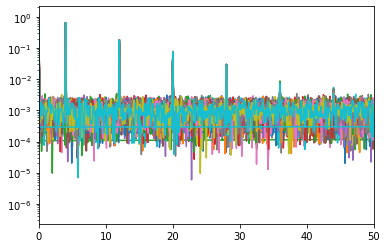

In [534]:
gain2 = []
gain2e = []

x = np.arange(0,tstop,1.0/samp)

for i in range(10):
    fstm = stm[i]
    flat = rflat/fstm/2
    tilt = (1-rflat)/4/fstm

    NMC = 50
    mpeak = []
    peaksum = 0
    
    for j in range(NMC):
        xf, y = GetSignal(x,tilt,flat,fstm)     
        peaksum += FindPeak(xf, y)
        mpeak.append(FindPeak(xf, y))
        if i ==2:
            plotFFT(xf,y)

    peak= peaksum/NMC
    noise = np.std(mpeak)
    
    gain2.append(peak)
    gain2e.append(noise)

    print(peak, noise)
        
f = stm
g2=np.array(gain2)
g2e=np.array(gain2e)

result= 0.004060504078022609   diff= 0.015126019505652157 error= 0.00015381683706727767


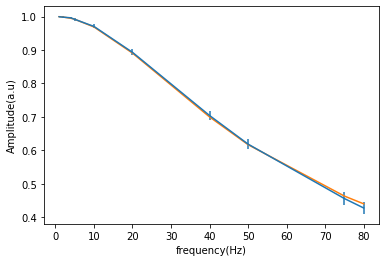

In [535]:
FitLPF(f,g1, g1e)

result= 0.003986421899085046   diff= -0.0033945252287384195 error= 7.149000508588355e-05


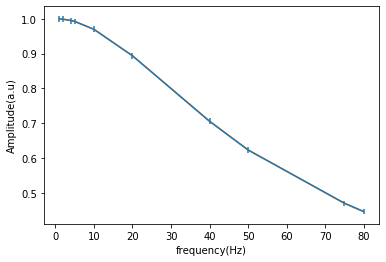

In [536]:
FitLPF(f,g2, 10*g2e)

1605


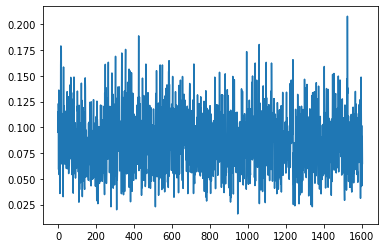

In [515]:
fstm = stm[1]
flat = rflat/fstm/2
tilt = (1-rflat)/4/fstm

x = np.arange(0,tstop,1.0/samp)


Nsp =  int(round(x[-1]*fstm))
xsp = np.array((np.array_split(x, Nsp)))
    
ys = RecWOP(xsp[0],tilt,flat)
    
xf = np.arange(0,len(ys)/samp,1.0/samp)

yexp = np.exp(-xf/tau)/tau
fft_exp = fftpack.fft(yexp)
fft_sig = fftpack.fft(ys)
    
in2 = fft_exp*fft_sig/samp
signal =  fftpack.ifft(in2)

sigsum = 0
sigmam = []
    
for i in range(Nsp):
    sigsum= sigsum+signal.real+np.random.normal(0, 1.0/SNR, len(xf))
    sigmam.append(signal.real+np.random.normal(0, 1.0/SNR, len(xf)))

#print(Nsp, sigmam[0])

print(len(np.mean(sigmam, axis = 0)))
plt.plot(np.std(sigmam, axis = 0))
#plt.plot(np.mean(sigmam, axis = 0))

In [389]:
fstm = stm[1]
flat = rflat/fstm/2
tilt = (1-rflat)/4/fstm

x = np.arange(0,tstop,1.0/samp)

NMC = 50
mpeak = []
peaksum = 0
    
for i in range(NMC):
    xf, y = GetSignal(x,tilt,flat,fstm)     
    peaksum += FindPeak(xf, y)
    mpeak.append(FindPeak(xf, y))

    peak= peaksum/NMC
    noise = np.std(mpeak)
    print(peak, noise)


    
gain2.append(peak)
gain2e.append(noise)


#plt.plot(xf,y)
#plt.xlim(0,1)


AttributeError: 'numpy.ndarray' object has no attribute 'argrelmax'

In [332]:
result1=[[1.0008336293521243,0.8644990198108536,0.8886542490292865,0.8959985509146158,1.0268612256504333,0.8924319097018256],
         [0.07253664918692396, -0.005714394661179498, -0.007812778114588657, 0.005501607730967924, 0.011424747255616222, 0.009518846114210493],
         [0.043979508092483084,0.038544269578102974,0.0312769403362256,0.02304063135559111,0.010876401481221647,0.012577430575168476],
         [0.2456002309750566,0.06418054622734387,0.013022980456657562,0.015368353607079013,0.007714361826994913, 0.011185223615795686]]

result2 = [[-0.00730660833397935,0.008908708666239759,0.001059945946427221,-0.017123669606045056,-0.013518178907162906,-0.010873744968803098],[-0.04600475873088681,-0.014648853396649793,-0.019133301175467375,-0.00564086745231708,7.628392831009884e-05,-0.001481988968441393],[-0.051311793821275965,-0.011123874373461864,0.02235638779609188,0.013402145375744808,8.265890623099931e-05,0.0019458613958111756],[-0.12801446919045062,-0.003692593481976515, 0.001303046334786076, 0.006756090690608445, -0.0031524644900724624,0.0006445966255048952]]

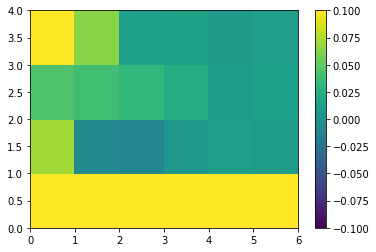

In [333]:
#X = [1,2,5,10,20,50]
#Y = [1.0, 0.8,0.5,0.2]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(result1, vmin=-0.1, vmax=0.1)
plt.colorbar()

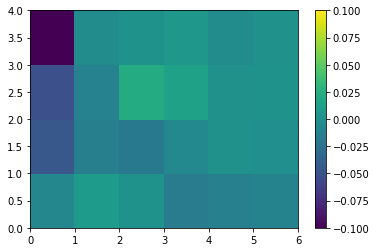

In [334]:
#xlabel = [1,2,5,10,20,50]
#ylabel = [1.0, 0.8,0.5,0.2]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(result2, vmin=-0.1, vmax=0.1)
plt.colorbar()